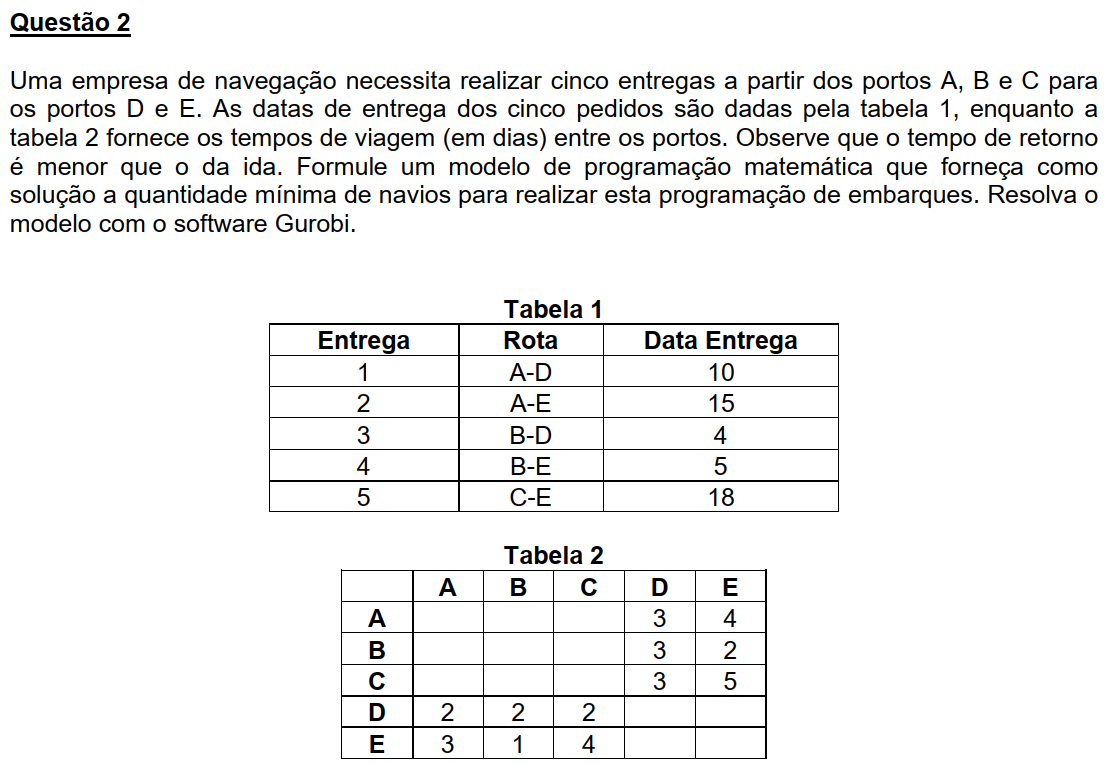

In [1]:
from IPython.display import Image
Image(filename='..\images\Questão_2.png')

In [6]:
import gurobipy as gp
import numpy as np

def imprime_resultados_geral(modelo):
    m = modelo
    print('=========================================')
    print('Quantidade de restrições: ', m.NumConstrs)
    print('Quantidade de variáveis: ', m.NumVars)
    print('=========================================')
    print('Status do modelo: ', m.Status)
    print('=========================================')
    print('Valor da função objetivo: ', m.ObjVal)
    print('=========================================')
    for v in m.getVars():  # m.getVars() retorna as variáveis do modelo
        if v.x != 0:
            print('%s %g' % (v.varName, v.x))
    print('=========================================')


'''################## Define os Parâmetros utilizados no modelo ##################'''
Data_entrega = np.array(
    [[0, 0, 0, 10, 15],
     [0, 0, 0, 4, 5],
     [0, 0, 0, 3, 18],
     [0, 0, 0, 0, 0],
     [0, 0, 0, 0, 0]])

Tempo_viagem = np.array(
    [[0, 0, 0, 3, 4],
     [0, 0, 0, 3, 2],
     [0, 0, 0, 3, 5],
     [2, 2, 2, 0, 0],
     [3, 1, 4, 0, 0]])

'''Cria o modelo'''
modelo = gp.Model(name="problema_das_entregas")

'''################## Define as variáveis utilizados no modelo ##################'''
quantidade_de_navios = 10

'''Define a rota do navio. Onde o indice i e j repretam os pares de coordendas (i,j) e k representam a 
quantidade máxima de navios que se tem disponível'''
Rota_navio = modelo.addVars(range(0, 5), range(0, 5), range(0, quantidade_de_navios),
                            vtype=gp.GRB.BINARY,
                            name='Rota_navio'
                            )

'''Tempo inicial em que um navio k realiza uma atividade na coordenada (i,j)'''
T_inicial = modelo.addVars(range(0, 5), range(0, 5), range(0, quantidade_de_navios),
                           vtype=gp.GRB.INTEGER,
                           lb=0,
                           name='T_inicial'
                           )

'''Tempo final em que um navio k finaliza uma atividade na coordenada (i,j)'''
T_final = modelo.addVars(range(0, 5), range(0, 5), range(0, quantidade_de_navios),
                         vtype=gp.GRB.INTEGER,
                         lb=0,
                         name='T_final'
                         )

'''Tempo de deslocamento de cada navio k para realizar uma atividade na coordenada (i,j)'''
Tempo_Deslocamento = modelo.addVars(range(0, 5), range(0, 5), range(0, quantidade_de_navios),
                                    vtype=gp.GRB.INTEGER,
                                    lb=0,
                                    name='Tempo_Deslocamento'
                                    )

'''Variável binária que representa se um navio foi utilzado para realizar uma atividade na coordenada (i,j)'''
k_navio = modelo.addVars(range(0, quantidade_de_navios),
                         vtype=gp.GRB.BINARY,
                         lb=0,
                         name='k_navio'
                         )

'''Variável binária que representa se uma rota (i,j) foi atendida por algum navio k'''
soma_rotas = modelo.addVars(range(0, 5), range(0, 5),
                            vtype=gp.GRB.BINARY,
                            lb=0,
                            name='soma_rotas'
                            )

'''################## Define as restrições utilizadas no modelo ##################'''

'''Define o tempo de deslocamento de cada navio para realizar uma rota (i,j) com duração do tempo de viagem de (i->j)'''
modelo.addConstrs((Tempo_Deslocamento[i, j, k] == Rota_navio[i, j, k] * Tempo_viagem[i][j]
                   for i in range(0, 5)
                   for j in range(0, 5)
                   for k in range(0, quantidade_de_navios)
                   ),
                  name='Restricao_1'
                  )

'''Define o tempo final de cada navio dado considerando o tempo inicial e o tempo de deslocamento de (i->j)'''
modelo.addConstrs((T_final[i, j, k] == T_inicial[i, j, k] + Tempo_Deslocamento[i, j, k]
                   for i in range(0, 5)
                   for j in range(0, 5)
                   for k in range(0, quantidade_de_navios)
                   ),
                  name='Restricao_2'
                  )

'''Define que o tempo final de cada navio deve ser menor ou igual a data de entrega (i,j)'''
modelo.addConstrs((T_final[i, j, k] <= Data_entrega[i][j]
                   for i in range(0, 5)
                   for j in range(0, 5)
                   for k in range(0, quantidade_de_navios)
                   ),
                  name='Restricao_3'
                  )

'''limita a escolha de apenas 1 destino j por origem i'''
modelo.addConstrs((gp.quicksum(Rota_navio[i, j, k] for i in range(0, 5)) <= 1 for j in range(0, 5) for k in
                   range(0, quantidade_de_navios)),
                  name='restricao_4'
                  )

'''limita a escolha de apenas 1 destino i por origem j'''
modelo.addConstrs((gp.quicksum(Rota_navio[i, j, k] for j in range(0, 5)) <= 1 for i in range(0, 5) for k in
                   range(0, quantidade_de_navios)),
                  name='restricao_5'
                  )

'Restrige diversas rotas proibidas que não devem ser percorridas pelos navios'
modelo.addConstrs((Rota_navio[0, 1, k] == 0 for k in range(0, quantidade_de_navios)))
modelo.addConstrs((Rota_navio[0, 2, k] == 0 for k in range(0, quantidade_de_navios)))
modelo.addConstrs((Rota_navio[1, 0, k] == 0 for k in range(0, quantidade_de_navios)))
modelo.addConstrs((Rota_navio[1, 2, k] == 0 for k in range(0, quantidade_de_navios)))
modelo.addConstrs((Rota_navio[2, 0, k] == 0 for k in range(0, quantidade_de_navios)))
modelo.addConstrs((Rota_navio[2, 1, k] == 0 for k in range(0, quantidade_de_navios)))
modelo.addConstrs((Rota_navio[3, 4, k] == 0 for k in range(0, quantidade_de_navios)))
modelo.addConstrs((Rota_navio[4, 3, k] == 0 for k in range(0, quantidade_de_navios)))

'''Esta restrição identifica se a rota (i,j) foi atendida por alguma sonda'''
modelo.addConstrs(
    (soma_rotas[i, j] == gp.quicksum(Rota_navio[i, j, k] * k_navio[k] for k in range(0, quantidade_de_navios)) for i in
     range(0, 5) for j in range(0, 5)),
    name='Restricao_7'
    )

'''Estas restrições garantem que as rotas a seguir sejam atendida por alguma sonda'''
modelo.addConstr(soma_rotas[0, 3] == 1)
modelo.addConstr(soma_rotas[0, 4] == 1)
modelo.addConstr(soma_rotas[1, 3] == 1)
modelo.addConstr(soma_rotas[1, 4] == 1)
modelo.addConstr(soma_rotas[2, 4] == 1)

'''Impede rotas para um mesmo destino, ou seja, i para i'''
modelo.addConstrs((Rota_navio[i, i, k] == 0 for i in range(0, 5) for k in range(0, quantidade_de_navios)),
                  name='restricao_9'
                  )

'''Define o total de navios utilizados'''
total_de_navios_utilizados = gp.quicksum(k_navio[k] for k in range(0, quantidade_de_navios))

'''Define a função objetivo como a minimização do total de navios utilizados'''
modelo.setObjective((total_de_navios_utilizados),
                    sense=gp.GRB.MINIMIZE)

'''Otimiza o modelo'''
modelo.optimize()

Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (win64)
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads
Optimize a model with 985 rows, 1035 columns and 2005 nonzeros
Model fingerprint: 0x26678d69
Model has 25 quadratic constraints
Variable types: 0 continuous, 1035 integer (285 binary)
Coefficient statistics:
  Matrix range     [1e+00, 5e+00]
  QMatrix range    [1e+00, 1e+00]
  QLMatrix range   [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 2e+01]
Presolve removed 935 rows and 964 columns
Presolve time: 0.00s
Presolved: 236 rows, 131 columns, 601 nonzeros
Variable types: 0 continuous, 131 integer (131 binary)
Found heuristic solution: objective 3.0000000

Root relaxation: cutoff, 53 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0     cut

In [7]:
'''Caso tenha encontrado alguma solução, imprime os resultados'''
if modelo.SolCount > 0:  # problema tem solução
    imprime_resultados_geral(modelo)

modelo.write("Modelo_questao_2.lp")
modelo.write("Solution_questao_2.sol")

Quantidade de restrições:  985
Quantidade de variáveis:  1035
Status do modelo:  2
Valor da função objetivo:  3.0
Rota_navio[0,3,9] 1
Rota_navio[0,4,8] 1
Rota_navio[1,3,8] 1
Rota_navio[1,4,9] 1
Rota_navio[2,4,7] 1
T_inicial[0,3,0] 10
T_inicial[0,3,1] 10
T_inicial[0,3,2] 10
T_inicial[0,3,3] 10
T_inicial[0,3,4] 10
T_inicial[0,3,5] 10
T_inicial[0,3,6] 10
T_inicial[0,3,7] 10
T_inicial[0,3,8] 10
T_inicial[0,3,9] 7
T_inicial[0,4,0] 15
T_inicial[0,4,1] 15
T_inicial[0,4,2] 15
T_inicial[0,4,3] 15
T_inicial[0,4,4] 15
T_inicial[0,4,5] 15
T_inicial[0,4,6] 15
T_inicial[0,4,7] 15
T_inicial[0,4,8] 11
T_inicial[0,4,9] 15
T_inicial[1,3,0] 4
T_inicial[1,3,1] 4
T_inicial[1,3,2] 4
T_inicial[1,3,3] 4
T_inicial[1,3,4] 4
T_inicial[1,3,5] 4
T_inicial[1,3,6] 4
T_inicial[1,3,7] 4
T_inicial[1,3,8] 1
T_inicial[1,3,9] 4
T_inicial[1,4,0] 5
T_inicial[1,4,1] 5
T_inicial[1,4,2] 5
T_inicial[1,4,3] 5
T_inicial[1,4,4] 5
T_inicial[1,4,5] 5
T_inicial[1,4,6] 5
T_inicial[1,4,7] 5
T_inicial[1,4,8] 5
T_inicial[1,4,9] 3
T_inici

O resultado obtido pelo modelo foram que a utilização de 3 sondas já atende ao problema e garantem que as entregas 
sejam realizadas até a data de entrega requerida.